In [ ]:
pip install opencv-python


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   -- ------------------------------------- 2.1/39.0 MB 11.2 MB/s eta 0:00:04
   ---- ----------------------------------- 4.5/39.0 MB 11.1 MB/s eta 0:00:04
   ------ --------------------------------- 6.8/39.0 MB 11.1 MB/s eta 0:00:03
   --------- ------------------------------ 9.2/39.0 MB 11.2 MB/s eta 0:00:03
   ----------- ---------------------------- 11.5/39.0 MB 11.2 MB/s eta 0:00:03
   -------------- ------------------------- 13.9/39.0 MB 11.2 MB/s eta 0:00:03
   ---------------- ----------------------- 16.3/39.0 MB 11.3 MB/s eta 0:00:03
   ------------------- -------------------- 18.6/39.0 MB 11.3 MB/s eta 0:00:02
   --------------------- ------------------ 21.0/39.0 MB 11.4 MB/s eta 0:00:02
   ----------------------- ---------------- 23.3/39.0 MB 11.4 MB/s eta 0:00:02
   -------------------------- ------------- 25.7/39.0 MB 11.4 MB/s eta 0:00:02
   ---------------------------- ----------- 28.0/39.0 MB 11.5 MB/

Classes found: ['actinic_keratoses', 'basal_cell_carcinoma', 'benign_keratosis-like_lesions', 'dermatofibroma', 'melanocytic_Nevi', 'melanoma', 'vascular_lesions']
Class to index mapping: {'actinic_keratoses': 0, 'basal_cell_carcinoma': 1, 'benign_keratosis-like_lesions': 2, 'dermatofibroma': 3, 'melanocytic_Nevi': 4, 'melanoma': 5, 'vascular_lesions': 6}
Class distribution: {np.int64(0): np.int64(315), np.int64(1): np.int64(487), np.int64(2): np.int64(1048), np.int64(3): np.int64(110), np.int64(4): np.int64(6405), np.int64(5): np.int64(1076), np.int64(6): np.int64(136)}


model.safetensors:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

c:\Users\akhil\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\akhil\.cache\huggingface\hub\models--timm--efficientformerv2_s0.snap_dist_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\akhil\AppData\Local\Temp\ipykernel_7052\344787538.py:91: FutureWarning: `torch.cuda.amp.GradSc

Epoch 1: Train Loss: 1.4341, Val Loss: 3.0709, Val Acc: 0.6577
Epoch 2: Train Loss: 0.9933, Val Loss: 1.2205, Val Acc: 0.7572
Epoch 3: Train Loss: 0.8343, Val Loss: 1.1339, Val Acc: 0.7893
Epoch 4: Train Loss: 0.6955, Val Loss: 2.3462, Val Acc: 0.8315
Epoch 5: Train Loss: 0.5933, Val Loss: 0.9504, Val Acc: 0.8102
Epoch 6: Train Loss: 0.5225, Val Loss: 0.8949, Val Acc: 0.8800
Epoch 7: Train Loss: 0.4458, Val Loss: 0.3844, Val Acc: 0.8756
Epoch 8: Train Loss: 0.3674, Val Loss: 0.4032, Val Acc: 0.8768
Epoch 9: Train Loss: 0.3378, Val Loss: 0.3230, Val Acc: 0.9061
Epoch 10: Train Loss: 0.3190, Val Loss: 0.5273, Val Acc: 0.8451
Epoch 11: Train Loss: 0.3009, Val Loss: 0.3079, Val Acc: 0.9001
Epoch 12: Train Loss: 0.2577, Val Loss: 0.2550, Val Acc: 0.9173
Epoch 13: Train Loss: 0.2142, Val Loss: 0.2966, Val Acc: 0.9021
Epoch 14: Train Loss: 0.1954, Val Loss: 0.2594, Val Acc: 0.9169
Epoch 15: Train Loss: 0.2081, Val Loss: 0.4520, Val Acc: 0.9101
Epoch 16: Train Loss: 0.1693, Val Loss: 0.1491, V

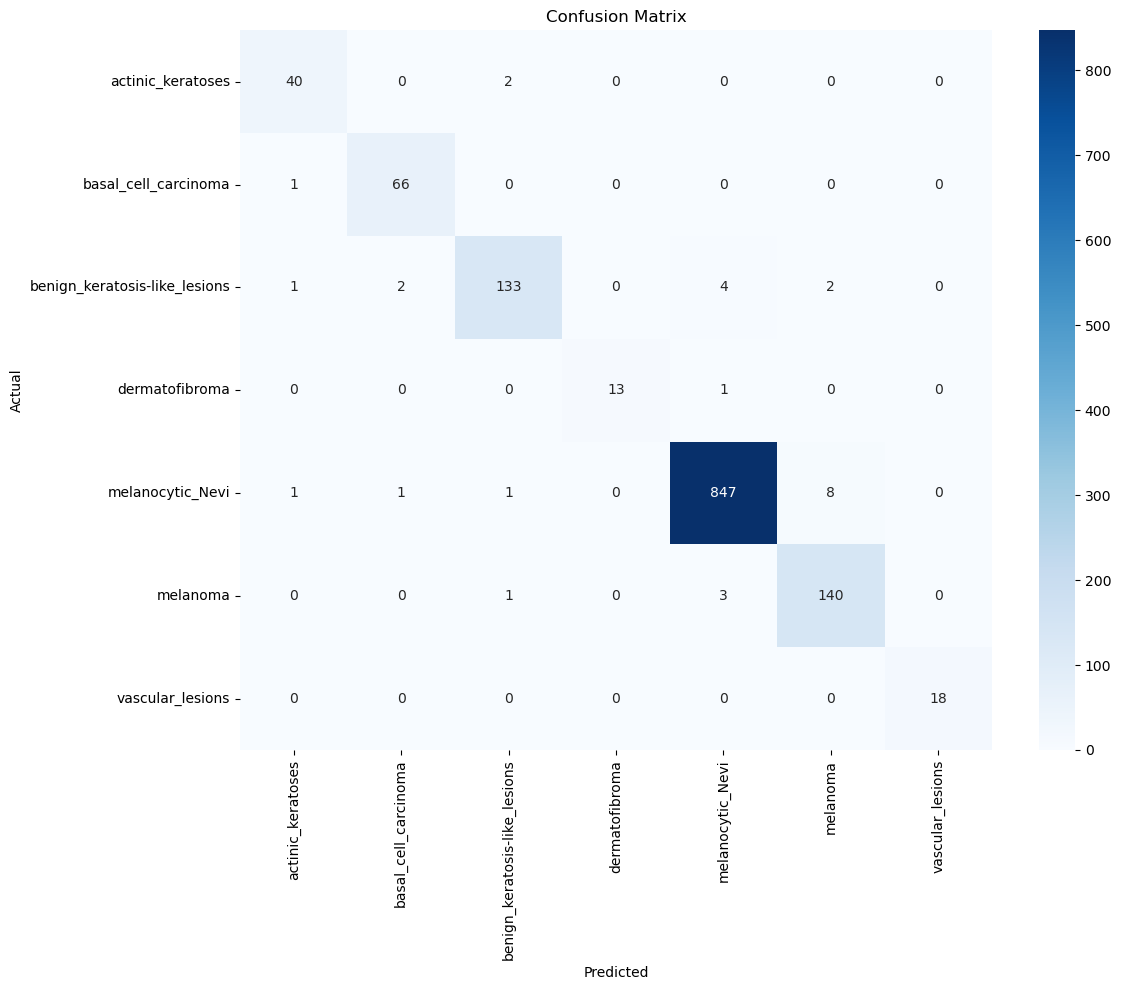

Using target layer: stages.3.blocks.3.mlp.mid.conv


c:\Users\akhil\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


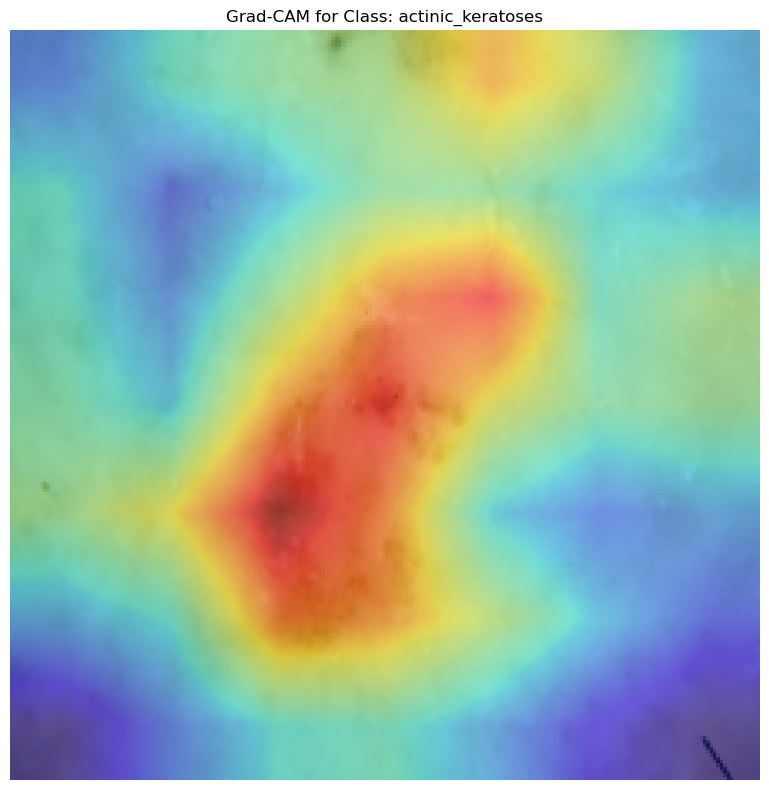

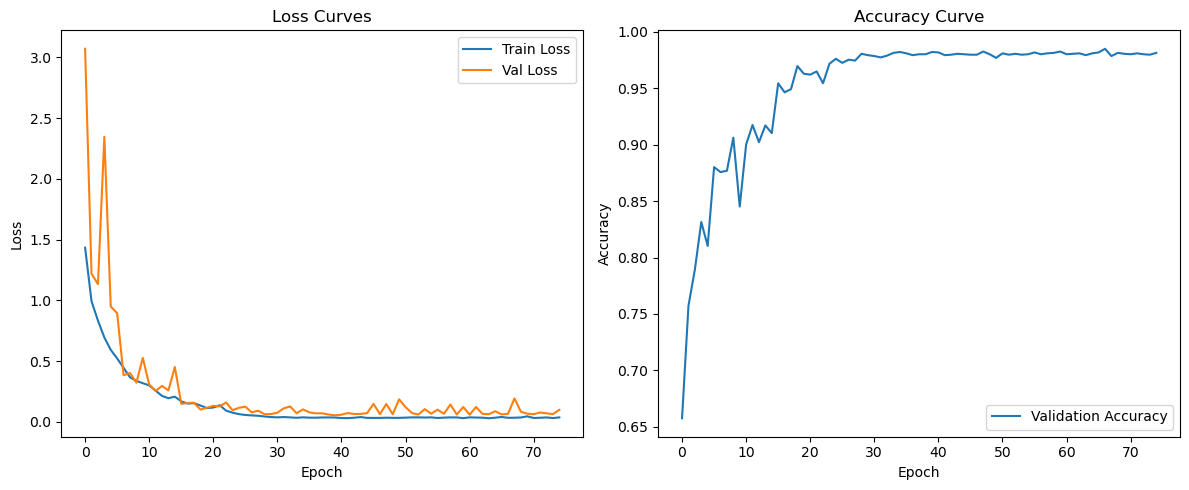

Training completed successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from timm.models import create_model
from timm.data import resolve_data_config
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
import cv2

ds = load_dataset("marmal88/skin_cancer")

classes = ds['train'].unique('dx')
class_to_idx = {cls: i for i, cls in enumerate(classes)}
print(f"Classes found: {classes}")
print(f"Class to index mapping: {class_to_idx}")

class SkinDataset(Dataset):
    def __init__(self, split, transform=None):
        self.dataset = ds[split]
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = class_to_idx[item['dx']]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

train_dataset = SkinDataset('train', transform=train_transform)
val_dataset = SkinDataset('validation', transform=val_test_transform)
test_dataset = SkinDataset('test', transform=val_test_transform)

train_labels = [class_to_idx[label] for label in ds['train']['dx']]
unique_labels, counts = np.unique(train_labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))
print("Class distribution:", class_counts)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=0, pin_memory=True)

model = create_model('efficientformerv2_s0', pretrained=True, num_classes=len(classes))
model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
scaler = torch.cuda.amp.GradScaler()

def train_epoch(epoch):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)

def validate(loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return val_loss / len(loader.dataset), correct / total

num_epochs = 75
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(epoch)
    val_loss, val_acc = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = val_loss

model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = validate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(classes))]

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

def grad_cam(model, input_tensor, target_class=None, target_layer_name=None):
    model.eval()

    conv_layers = []
    layer_names = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and module.kernel_size != (1, 1):
            conv_layers.append(module)
            layer_names.append(name)

    if not conv_layers:
        raise ValueError("No suitable Conv2d layers found in model")

    if target_layer_name:
        target_layer = dict(model.named_modules())[target_layer_name]
        if not isinstance(target_layer, nn.Conv2d):
            raise ValueError(f"Target layer {target_layer_name} is not a Conv2d layer")
    else:
        target_layer = conv_layers[-1]
        target_layer_name = layer_names[-1]

    print(f"Using target layer: {target_layer_name}")

    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle1 = target_layer.register_forward_hook(forward_hook)
    handle2 = target_layer.register_backward_hook(backward_hook)

    try:
        output = model(input_tensor)
        if target_class is None:
            target_class = output.argmax().item()

        model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        if not gradients or not activations:
            raise RuntimeError("No gradients or activations captured")

        grad = gradients[0].cpu().data.numpy()
        act = activations[0].cpu().data.numpy()

        weights = np.mean(grad, axis=(2, 3), keepdims=True)
        cam = np.sum(weights * act, axis=1)

        cam = np.maximum(cam, 0)

        cam = cam / (np.max(cam) + 1e-8) if np.max(cam) > 0 else cam

        cam = cam[0]
        cam = cv2.resize(cam, (224, 224), interpolation=cv2.INTER_LINEAR)
        cam = np.clip(cam, 0, 1)

        return cam

    finally:
        handle1.remove()
        handle2.remove()

input_tensor = next(iter(test_loader))[0][:1].cuda()
with torch.no_grad():
    output = model(input_tensor)
    target_class = output.argmax().item()

target_layer_name = None
cam = grad_cam(model, input_tensor, target_class, target_layer_name)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = input_tensor.squeeze().cpu().numpy()
img = img.transpose(1, 2, 0)
img = img * std + mean
img = np.clip(img, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5, interpolation='bilinear')
plt.title(f"Grad-CAM for Class: {idx_to_class[target_class]}")
plt.axis('off')
plt.tight_layout()
plt.savefig('grad_cam.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300)
plt.show()

print("Training completed successfully!")
```import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from timm.models import create_model
from timm.data import resolve_data_config
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
import cv2

ds = load_dataset("marmal88/skin_cancer")

classes = ds['train'].unique('dx')
class_to_idx = {cls: i for i, cls in enumerate(classes)}
print(f"Classes found: {classes}")
print(f"Class to index mapping: {class_to_idx}")

class SkinDataset(Dataset):
    def __init__(self, split, transform=None):
        self.dataset = ds[split]
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = class_to_idx[item['dx']]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

train_dataset = SkinDataset('train', transform=train_transform)
val_dataset = SkinDataset('validation', transform=val_test_transform)
test_dataset = SkinDataset('test', transform=val_test_transform)

train_labels = [class_to_idx[label] for label in ds['train']['dx']]
unique_labels, counts = np.unique(train_labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))
print("Class distribution:", class_counts)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=0, pin_memory=True)

model = create_model('efficientformerv2_s0', pretrained=True, num_classes=len(classes))
model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
scaler = torch.cuda.amp.GradScaler()

def train_epoch(epoch):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)

def validate(loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return val_loss / len(loader.dataset), correct / total

num_epochs = 75
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(epoch)
    val_loss, val_acc = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = val_loss

model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = validate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(classes))]

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

def grad_cam(model, input_tensor, target_class=None, target_layer_name=None):
    """
    Compute Grad-CAM heatmap for a given input and model.

    Args:
        model: PyTorch model (EfficientFormerV2-S0)
        input_tensor: Input image tensor (1, C, H, W) on CUDA
        target_class: Class index to visualize (default: predicted class)
        target_layer_name: Name of target conv layer (default: last suitable layer)

    Returns:
        cam: Heatmap aligned with input image dimensions
    """
    model.eval()

    conv_layers = []
    layer_names = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and module.kernel_size != (1, 1):
            conv_layers.append(module)
            layer_names.append(name)

    if not conv_layers:
        raise ValueError("No suitable Conv2d layers found in model")

    if target_layer_name:
        target_layer = dict(model.named_modules())[target_layer_name]
        if not isinstance(target_layer, nn.Conv2d):
            raise ValueError(f"Target layer {target_layer_name} is not a Conv2d layer")
    else:
        target_layer = conv_layers[-1]
        target_layer_name = layer_names[-1]

    print(f"Using target layer: {target_layer_name}")

    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle1 = target_layer.register_forward_hook(forward_hook)
    handle2 = target_layer.register_backward_hook(backward_hook)

    try:
        output = model(input_tensor)
        if target_class is None:
            target_class = output.argmax().item()

        model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        if not gradients or not activations:
            raise RuntimeError("No gradients or activations captured")

        grad = gradients[0].cpu().data.numpy()
        act = activations[0].cpu().data.numpy()

        weights = np.mean(grad, axis=(2, 3), keepdims=True)
        cam = np.sum(weights * act, axis=1)

        cam = np.maximum(cam, 0)

        cam = cam / (np.max(cam) + 1e-8) if np.max(cam) > 0 else cam

        cam = cam[0]
        cam = cv2.resize(cam, (224, 224), interpolation=cv2.INTER_LINEAR)
        cam = np.clip(cam, 0, 1)

        return cam

    finally:
        handle1.remove()
        handle2.remove()

input_tensor = next(iter(test_loader))[0][:1].cuda()
with torch.no_grad():
    output = model(input_tensor)
    target_class = output.argmax().item()

target_layer_name = None
cam = grad_cam(model, input_tensor, target_class, target_layer_name)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = input_tensor.squeeze().cpu().numpy()
img = img.transpose(1, 2, 0)
img = img * std + mean
img = np.clip(img, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5, interpolation='bilinear')
plt.title(f"Grad-CAM for Class: {idx_to_class[target_class]}")
plt.axis('off')
plt.tight_layout()
plt.savefig('grad_cam.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300)
plt.show()

print("Training completed successfully!")